In [1]:
from besos import eppy_funcs as ef
from besos import sampling
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, Parameter, FieldSelector
from besos import config

from sklearn import svm, pipeline, linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact, FloatSlider

## Setup

We begin by loading a representation of a builing. The default is a small office, which will be used for this example.

In [2]:
building = ef.get_building()

Then define how we would like to modify the building. We choose to change the direction that it is facing, and modify the efficency of the lights.

In [3]:
parameters = [
    Parameter(FieldSelector(object_name='NonRes Fixed Assembly Window',
                                field_name='Solar Heat Gain Coefficient'),
                  value_descriptor=RangeParameter(0.01,0.99)),
    Parameter(FieldSelector('Lights', '*', 'Watts per Zone Floor Area'),
                  value_descriptor=RangeParameter(8, 12),
                  name='Lights Watts/Area')]

Now we specify that we would like to measure the electricity use of the entire facility. We then bundle all of this information together.

## Simulation

In [4]:
objectives = ['Electricity:Facility']

problem = EPProblem(parameters, objectives)

We can generate some samples train the model on them. If you do not want to wait for the simulation, skip the next code cell.

The sampler uses latin hypercube sampling to distribute the samples, and scales them appropriately.

Here are the inputs that it

In [5]:
inputs = sampling.dist_sampler(sampling.lhs, problem, 5)
inputs

Solar Heat Gain Coefficient  Lights Watts/Area
0                     0.390438           9.479972
1                     0.091444          11.543718
2                     0.793292           9.609679
3                     0.543282          10.862064
4                     0.887609           8.395031

In [6]:
evaluator = EvaluatorEP(problem, building)
train = evaluator.df_apply(inputs, keep_input=True)
train.head() # display the first 5

Solar Heat Gain Coefficient  Lights Watts/Area  Electricity:Facility
0                     0.390438           9.479972          1.770917e+09
1                     0.091444          11.543718          1.818427e+09
2                     0.793292           9.609679          1.940715e+09
3                     0.543282          10.862064          1.904238e+09
4                     0.887609           8.395031          1.908738e+09

We can also load some saved simulation results for this building. 1000 results are loaded.

In [7]:
#train = pd.read_pickle(config.data_dir.joinpath('SHGC_and_lights.p'))

#train.head()

In [8]:
x,y,c = problem.names()
x,y,c

('Solar Heat Gain Coefficient', 'Lights Watts/Area', 'Electricity:Facility')

Here is a plot of the training data we will use.

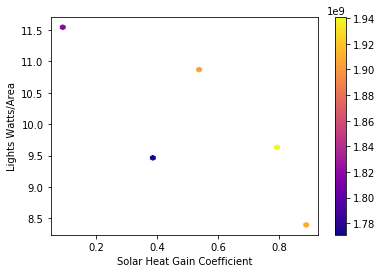

In [9]:
train.plot.hexbin(x=x, y=y, C=c, cmap='plasma', sharex=False, gridsize=50)

In [10]:
def train_and_plot(density=80):
    model = pipeline.make_pipeline(
        StandardScaler(),
        linear_model.Ridge())
    model.fit(train[[x, y]].values, train[c].values)
    # works for at least density <= 1000, may cause some holes beyond that
    df = get_plot_data(model, density=int(density*1.5))
    df.plot.hexbin(x=x, y=y, C=0, cmap='plasma', gridsize=density, sharex=False)
    return model

def get_plot_data(model, density):
    p1 = problem.inputs[0].value_descriptor
    a = np.linspace(p1.min, p1.max, density)
    p2 = problem.inputs[1].value_descriptor
    b = np.linspace(p2.min, p2.max, density)
    plot_data = pd.DataFrame(np.transpose([np.tile(a, len(b)), np.repeat(b, len(a))]),
                             columns=problem.names('inputs'))
    return pd.concat([plot_data, pd.Series(model.predict(plot_data))], axis=1)

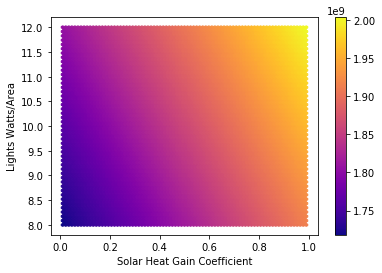

In [11]:
model = train_and_plot()

In [12]:
# this cell uses the model to generate the requested prediction

(min1, max1), (min2, max2) = ((float(p.value_descriptor.min ), p.value_descriptor.max)
                              for p in problem.inputs)
density = 30
df = get_plot_data(model, int(density*1.5))

def model_wrapper(North_Axis, Watts):
    df.plot.hexbin(x=x, y=y, C=0, cmap='plasma', gridsize=30, sharex=False)
    x_lims = plt.xlim()
    y_lims = plt.ylim()
    plt.scatter(x=[North_Axis], y=[Watts])
    plt.xlim((x_lims))
    plt.ylim((y_lims))

    return model.predict([[North_Axis, Watts]])[0]

def avg(a,b):
    return (a+b)/2

continuous_update=False
interact(model_wrapper,
         North_Axis=FloatSlider(min=min1, max=max1, value=avg(min1, max1),
                                step=0.01, continuous_update=continuous_update),
         Watts=FloatSlider(min=min2, max=max2, value=avg(min2, max2),
                           continuous_update=continuous_update))

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='North_Axis', max=0.99, min=…

<function __main__.model_wrapper(North_Axis, Watts)>